In [22]:
# -*- coding: utf-8 -*-
import openmc
import os
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import sys
from PIL import Image
import numpy as np
import pandas as pd

In [23]:
from pathlib import Path
import sys 
CWD = Path.cwd().resolve()
project_root = Path.cwd().parents[2]
sys.path.append(str(project_root))
from src.utils.common.isotope import Radionuclide_lara

In [24]:
df = pd.read_csv("rn.csv", sep=";")
# modify the format of the Radionuclide name : change 54Mn to Mn-54 for example
df["Radionuclide"] = df["Radionuclide"].apply(lambda x: f"{''.join(filter(str.isalpha, x))}-{''.join(filter(str.isdigit, x))}")

In [25]:
dict_rn = df.set_index("Radionuclide").to_dict()["Mass[g]"]


In [26]:
dict_rn

{'Mn-54': 0.0002,
 'Co-58': 0.0003,
 'Co-60': 0.0005,
 'Fe-59': 0.0001,
 'Cr-51': 0.0004,
 'Co-57': 0.0002,
 'Zn-65': 0.0001,
 'Fe-55': 0.0002,
 'Mn-56': 0.0003,
 'Na-22': 0.0001}

Calcul du terme source après 0 seconde

In [27]:
rays = []
weights = []
for rn, mass in dict_rn.items():
    rn_lara = Radionuclide_lara(rn)
    energy, intensity, _ = rn_lara.get_rays_emission_data(photon_only=True)
    act = rn_lara.get_activity_after_time(mass=mass, time=0)
    rays.extend(energy)
    weights.extend(intensity * act)
total_weight = sum(weights)

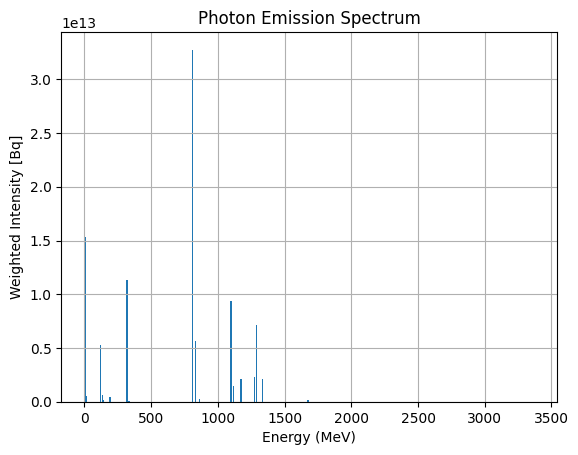

In [29]:
plt.bar(rays, weights, width=10)
plt.xlabel("Energy (MeV)")
plt.ylabel("Weighted Intensity [Bq]")
plt.title("Photon Emission Spectrum")
plt.grid(True)
plt.show()

Caclcul of the activity after several points of time

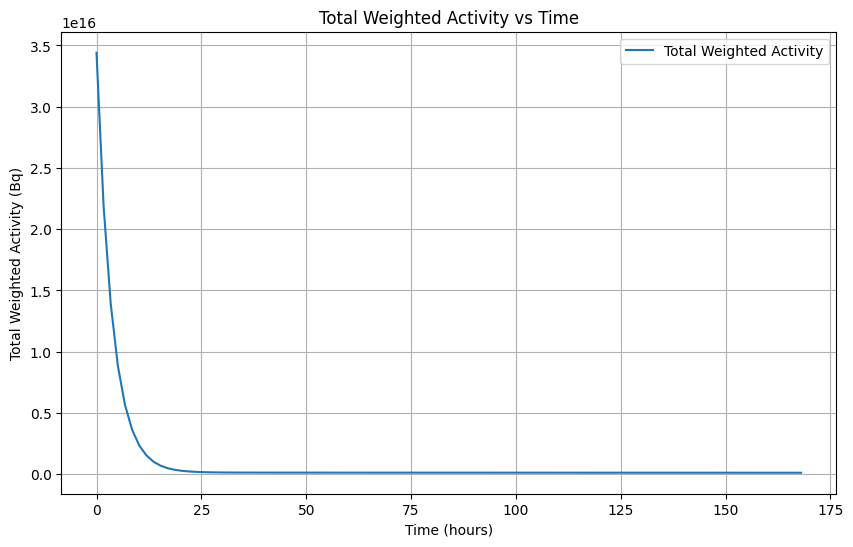

In [28]:
time_points = np.linspace(0, 3600 * 24 * 7, 100)  # 7 days in seconds
total_weight_at_time = []
for time in time_points:
    rays = []
    weights = []
    for rn, mass in dict_rn.items():
        rn_lara = Radionuclide_lara(rn)
        energy, intensity, _ = rn_lara.get_rays_emission_data(photon_only=True)
        act = rn_lara.get_activity_after_time(mass=mass, time=time)
        rays.extend(energy)
        weights.extend(intensity * act)
    total_weight = sum(weights)
    total_weight_at_time.append(total_weight)

plt.figure(figsize=(10, 6))
plt.plot(time_points / 3600, total_weight_at_time, label="Total Weighted Activity")
plt.xlabel("Time (hours)")
plt.ylabel("Total Weighted Activity (Bq)")
plt.title("Total Weighted Activity vs Time")
plt.legend()
plt.grid(True)
plt.show()

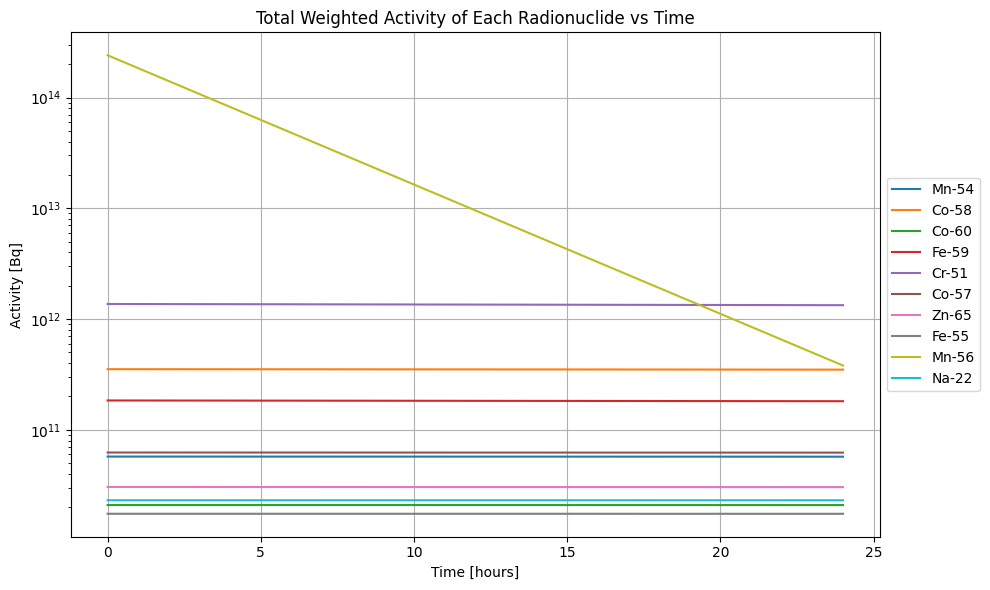

In [36]:
# plot the total weighted activity of every radionuclide vs time
# Calculate and plot the total weighted activity of every radionuclide vs time

time_points = np.linspace(0, 3600 * 24, 100)  # 1 day in seconds
total_weights_per_rn = {}
for rn, mass in dict_rn.items():
    rn_lara = Radionuclide_lara(rn)
    # Compute activity at each time point for this radionuclide
    activities = np.array([rn_lara.get_activity_after_time(mass=mass, time=t) for t in time_points])
    total_weights_per_rn[rn] = activities

# Plot
plt.figure(figsize=(10, 6))
for rn, activities in total_weights_per_rn.items():
    plt.plot(time_points / (3600), activities, label=rn)
plt.xlabel("Time [hours]")
plt.ylabel("Activity [Bq]")
plt.title("Total Weighted Activity of Each Radionuclide vs Time")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
plt.show()